## 순전파 - 역전파

- 미분으로 각 가중치가 loss에 미치는 영향(기울기)를 알 수 있음
- loss를 0으로 만드는 방향으로 각 변수를 조정함(Gradient Dscent)
- 미분값(기울기)가 양수이면 음의 방향으로, 음수이면 양의 방향으로 조정이 진행됨
- <현재 가중치 = 이전 가중치 - 학습률*기울기(미분)>이므로, 현재 가중치가 변화하게 됨
- 현재 가중치가 변화함에 따라 순전파의 출력값이 변하고, 역전파로 돌아올 때의 기울기도 변화하게 됨
- 기울기가 변화한 값을 반영하게 현재 가중치가 다시 조정되고, 기울기(미분)이 0이 되어 가중치 조정이 일어나지 않을 때까지 오차역전파를 통한 가중치 조정이 진행됨

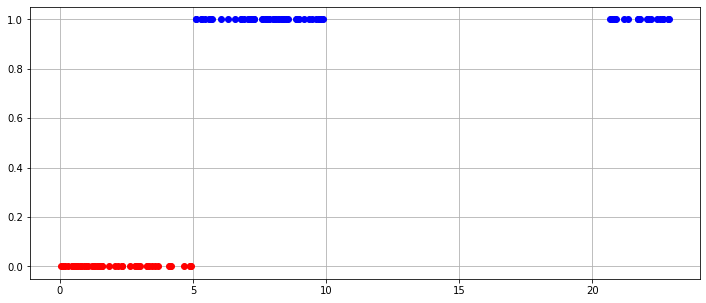

In [18]:
#데이터 만들기

import numpy as np
np.random.seed(0)

#난수 생성

x1 = np.random.uniform(low = 5, high = 10, size = (50,))
x2 = np.random.uniform(low = 0, high = 5, size = (50,))

#타겟 생성

y1 = np.ones_like(x1)
y2 = np.zeros_like(x2)

#outlier 생성

outlier = np.random.uniform(low = 20, high = 23, size = 20)
y_outlier = np.ones_like(outlier)

#outlier 붙이기

x1 = np.append(x1, outlier)
y1 = np.append(y1, y_outlier)

#데이터 하나로 만들기
x_data = np.hstack([x1, x2])
y_data = np.hstack([y1, y2])

#시각화
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (12, 5))
ax.plot(x_data[:70], y_data[:70], 'bo')
ax.plot(x_data[70:], y_data[70:], 'ro')
ax.grid() 

In [24]:
class plus_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None

    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x + self._y
        return self._z

    def backward(self, dz):
        return dz, dz #도함수의 가중치와 이전 노드의 가중치

class minus_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None 

    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x - self._y
        return self._z

    def backward(self, dz):
        return dz, -1*dz

class mul_node:
    def __init__(self):
        self._x, self._y = None, None
        self._z = None
    
    def forward(self, x, y):
        self._x, self._y = x, y
        self._z = self._x * self._y
        return self._z
    
    def backward(self, dz):
        return dz * self._y, dz * self._x

class square_node:
    def __init__(self):
        self._x = None
        self._z = None
    
    def forward(self, x):
        self._x = x
        self._z = self._x * self._x
        return self._z

    def backward(self, dz):
        return dz * 2 * self._x

class mean_node:
    def __init__(self):
        self._x = None
        self._z = None

    def forward(self, x):
        self._x = x
        self._z = np.mean(self._x)
        return self._z
    
    def backward(self, dz):
        dx = dz*1/len(self._x)*np.ones_like(self._x)
        return dx

class sigmoid_node():
    def __init__(self):
        self.x, self.y = None, None
        
    def forward(self, x):
        self.x, self.y = x, 1/(1+np.exp(-1*x))
        return self.y
    def backward(self, dL):
        return dL * self.y * (1 - self.y)

In [28]:
mul = mul_node()
plus = plus_node()
sigmoid = sigmoid_node()
minus = minus_node()
square = square_node()
mean = mean_node()

dJ = 1 #역전파의 첫 값
th_list = [0.1, 0.1] #가중치, 편향
lr = 0.5 #학습률
epochs = 200000
cost_list = [] #비용 함수(Loss)를 담을 list
th1_list, th0_list = [], [] #가중치, 편향의 변화를 담을 list

for i in range(epochs):
    Z1 = mul.forward(th_list[1],x_data) #가중치 곱
    Z2 = plus.forward(Z1,th_list[0]) #편향 합
    Z3 = sigmoid.forward(Z2) #활성 함수
    Z4 = minus.forward(y_data,Z3) #오차
    L = square.forward(Z4) #오차 제곱
    J = mean.forward(L) #오차 제곱의 평균
    
    dL = mean.backward(dJ) #오차 제곱 평균의 도함수
    dZ4 = square.backward(dL) #오차 제곱 평균 도함수의 도함수(chain rule)
    dY, dZ3 = minus.backward(dZ4) #dz4의 도함수
    dZ2 = sigmoid.backward(dZ3) #dz3의 도함수
    dZ1, dTheta0 = plus.backward(dZ2) #dz2의 도함수, 편향의 도함수
    dTheta1, dX = mul.backward(dZ1) #dz1의 도함수, 가중치의 도함수

    th_list[1] = th_list[1] - lr*np.sum(dTheta1) #새롭게 경신된 가중치 = 기존 가중치 - 해당 지점에서 기울기(가중치의 손실함수)
    th_list[0] = th_list[0] - lr*np.sum(dTheta0) #새롭게 경신된 가중치 = 기존 가중치 - 해당 지점에서 기울기(편향의 순실함수)
    
    cost_list.append(J)
    th1_list.append(th_list[1])
    th0_list.append(th_list[0])

In [29]:
#가중치, 편향의 최종값

th_list

[-35.24417681400883, 7.021766761474626]

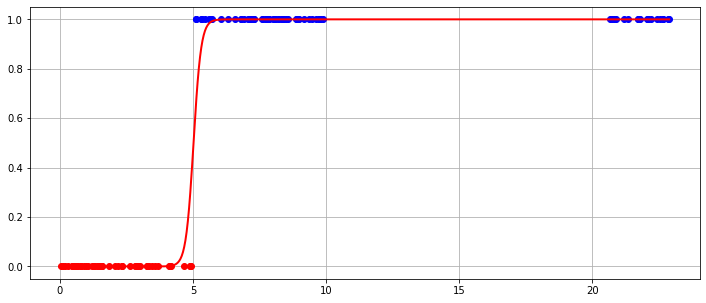

In [30]:
#학습 결과 시각화

x_min, x_max = x_data.min(), x_data.max()
y_min, y_max = sigmoid.forward(x_min*th_list[1] + th_list[0]), sigmoid.forward(x_max*th_list[1] + th_list[0]) #신경망 학습 구현 : 가중치 * 특성값 + 편향
x_range = np.linspace(x_min, x_max, 1000) #최대값과 최소값 사이의 데이터 생성
y_range = sigmoid.forward(x_range*th_list[1] + th_list[0]) #생성한 데이터로 신경망 학습 진행

fig, ax = plt.subplots(figsize = (12,5))
ax.plot(x_data[:70], y_data[:70], 'bo')
ax.plot(x_data[70:], y_data[70:], 'ro')
ax.plot(x_range, y_range, 'r', linewidth = 2)
ax.grid()

In [31]:
#ReLU 함수

class Relu:
    def __init__(self):
        self.mask = None
    
    def forward(self, x):
        self.mask = (x <= 0) #0보다 작은 원소는 True, 0보다 큰 원소는 False
        out = x.copy()
        out[self.mask] = 0

    def backward(self, dout):
        dout[self.mask] = 0 #순전파에서 0보다 작았던 원소(True)를 0으로 반환함
        dx = dout
        return dx